# Load the Data Using Panda

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df =  pd.read_csv("velocitiesblock01.txt", header=None)

In [3]:
df.head(10)

,0,1,2
0,gvel: 0.0,0.0,0.000
1,gvel: 0.0,0.0,-0.049
2,gvel: 0.037,-0.0,-0.052
3,gvel: 0.068,-0.0,-0.064
4,gvel: 0.095,-0.0,-0.080
5,gvel: 0.12,-0.0,-0.098
6,gvel: 0.145,-0.0,-0.118
7,gvel: 0.145,-0.0,-0.167
8,gvel: 0.181,0.0,-0.171
9,gvel: 0.211,0.0,-0.183


In [4]:
step = df.index.values
step[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [5]:
v_x = df[0].apply(lambda x: float(x.strip('gvel: '))).values

In [6]:
v_x[:10]

array([0.   , 0.   , 0.037, 0.068, 0.095, 0.12 , 0.145, 0.145, 0.181,
       0.211])

In [7]:
v_z = df[2].apply(float).values

In [8]:
v_z[:10]

array([ 0.   , -0.049, -0.052, -0.064, -0.08 , -0.098, -0.118, -0.167,
       -0.171, -0.183])

# Get the Velocity Magnitude

In [9]:
df[3] = np.sqrt(v_x**2 + v_z**2)
v = df[3].values

In [13]:
df = df.rename(columns = {0: "v_x", 2:"v_y", 3:"v_norm"})
df['step'] = step
df.head()

,v_x,1,v_y,v_norm,step
0,gvel: 0.0,0.0,0.000,0.000000,0
1,gvel: 0.0,0.0,-0.049,0.049000,1
2,gvel: 0.037,-0.0,-0.052,0.063820,2
3,gvel: 0.068,-0.0,-0.064,0.093381,3
4,gvel: 0.095,-0.0,-0.080,0.124197,4


In [12]:
v[:10]

array([0.        , 0.049     , 0.06382006, 0.09338094, 0.12419742,
       0.15493224, 0.18694652, 0.2211651 , 0.24900201, 0.2793027 ])

# Plot the X, Z components and Magnitude

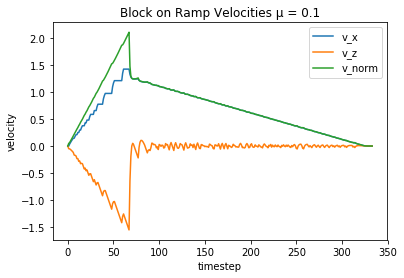

In [14]:
fig, ax = plt.subplots()
ax.plot(step, v_x, label="v_x")
ax.plot(step, v_z, label="v_z")
ax.plot(step, v, label="v_norm")
ax.legend()
ax.set_title("Block on Ramp Velocities μ = 0.1")
ax.set_ylabel("velocity")
ax.set_xlabel("timestep");

# Calculate Friction Coefficient

Let's try to fit a line through v_norm using linear regression. First we need to determine exact timestep where the block exits the ramp.

In [16]:
prev_vel = -1*float("inf")
for i, vel in enumerate(v):
    if vel < prev_vel:
        print("Velocity decreasing at timestep {}".format(i))
        print("Velocity went from {:0.4f} to {:0.4f}".format(prev_vel, vel))
        break
    prev_vel = vel

Velocity decreasing at timestep 68
Velocity went from 2.1021 to 1.4750


In [29]:
step_ramp = df.iloc[0:68]["step"].values.reshape(-1, 1)
v_ramp = df.iloc[0:68] ["v_norm"].values.reshape(-1, 1)

In [30]:
from sklearn.linear_model import LinearRegression
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(step_ramp, v_ramp)  # perform linear regression
v_pred = linear_regressor.predict(step_ramp)  # make predictions

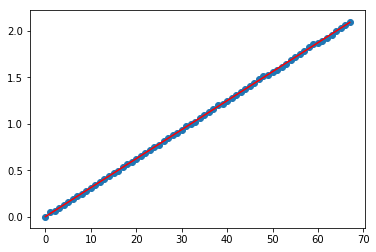

In [33]:
plt.scatter(step_ramp, v_ramp)
plt.plot(step_ramp, v_pred, color='red')
plt.show()

The acceleration is simply the slope of the fit.

In [39]:
a = linear_regressor.coef_[0][0]
print("The block fell down the ramp with an acceleration of {:0.4f} m/s^2".format(a))

The block fell down the ramp with an acceleration of 0.0312 m/s^2


# Repeat For Sphere

Sphere starts at same coordinates as block and has diameter = 0.025, which is also width and height of block (depth is 0.05)

In [ ]:
df =  pd.read_csv("velocitiessphere01.txt", header=None)

In [ ]:
step = df.index.values
v_x = df[0].apply(lambda x: float(x.strip('gvel: '))).values
v_z = df[2].apply(float).values
df[3] = np.sqrt(v_x**2 + v_z**2)
v = df[3].values

## Plot it

In [ ]:
fig, ax = plt.subplots()
ax.plot(step, v_x, label="v_x")
ax.plot(step, v_z, label="v_z")
ax.plot(step, v, label="v_norm")
ax.legend()
ax.set_title("Sphere on Ramp Velocities μ = 0.1")
ax.set_ylabel("velocity")
ax.set_xlabel("timestep");

# Try to Limit Bouncing of Sphere

Taking a closer look at z-component of velocity, we see, it dosn't actually go to exactly zero after it exits the ramp, but rather there is some bouncing effect.

In [ ]:
fig, ax = plt.subplots()
ax.plot(step, v_z, label="v_z")
ax.legend()
ax.set_title("Sphere on Ramp Velocities μ = 0.1")
ax.set_ylabel("velocity")
ax.set_xlabel("timestep")
ax.set_xlim(70, 160)
ax.set_ylim(-0.05, 0.15);

In [ ]:
df.iloc[70:95][2]

In [ ]:
df.iloc[110:120][2]

The initial bounce druves the z-component of velocity up to 0.140 at t=74. Then the sphere starts slowing down, but is still travelling upward until t=88. The sphere makes one more bounce, but then hits a resting velocity at t=111

# Turn on Condim = 6 to Provide Rotational Friction

In [ ]:
df =  pd.read_csv("velocitiessphere02.txt", header=None)
step = df.index.values
v_x = df[0].apply(lambda x: float(x.strip('gvel: '))).values
v_z = df[2].apply(float).values
df[3] = np.sqrt(v_x**2 + v_z**2)
v = df[3].values

In [ ]:
fig, ax = plt.subplots()
ax.plot(step, v_x, label="v_x")
ax.plot(step, v_z, label="v_z")
ax.plot(step, v, label="v_norm")
ax.legend()
ax.set_title("Sphere on Ramp Velocities μ = 0.1 0.005 0.0001, Condim=6")
ax.set_ylabel("velocity")
ax.set_xlabel("timestep");

Bouncing is noticeably worse, and does not converge to 0 well after 1000 time steps. Try increasing other friction components.

# Increase All Friction Params and Ball stops, but still bounces

In [ ]:
df =  pd.read_csv("velocitiessphere03.txt", header=None)
step = df.index.values
v_x = df[0].apply(lambda x: float(x.strip('gvel: '))).values
v_z = df[2].apply(float).values
df[3] = np.sqrt(v_x**2 + v_z**2)
v = df[3].values

In [ ]:
fig, ax = plt.subplots()
ax.plot(step, v_x, label="v_x")
ax.plot(step, v_z, label="v_z")
ax.plot(step, v, label="v_norm")
ax.legend()
ax.set_title("Sphere on Ramp Velocities μ = 0.2 0.05 0.01, Condim=6")
ax.set_ylabel("velocity")
ax.set_xlabel("timestep");

Indeed, bouncing seems worse here. Sphere even bounces as it falls down ramp. Let's actually decrease rotational and torsional frictions.

In [ ]:
df =  pd.read_csv("velocitiessphere04.txt", header=None)
step = df.index.values
v_x = df[0].apply(lambda x: float(x.strip('gvel: '))).values
v_z = df[2].apply(float).values
df[3] = np.sqrt(v_x**2 + v_z**2)
v = df[3].values

In [ ]:
fig, ax = plt.subplots()
ax.plot(step, v_x, label="v_x")
ax.plot(step, v_z, label="v_z")
ax.plot(step, v, label="v_norm")
ax.legend()
ax.set_title("Sphere on Ramp Velocities μ = 0.2 0.05 0.00001, Condim=6")
ax.set_ylabel("velocity")
ax.set_xlabel("timestep");

Let's try to eliminate bouncing on the ramp

In [ ]:
df =  pd.read_csv("velocitiessphere05.txt", header=None)
step = df.index.values
v_x = df[0].apply(lambda x: float(x.strip('gvel: '))).values
v_z = df[2].apply(float).values
df[3] = np.sqrt(v_x**2 + v_z**2)
v = df[3].values

In [ ]:
fig, ax = plt.subplots()
ax.plot(step, v_x, label="v_x")
ax.plot(step, v_z, label="v_z")
ax.plot(step, v, label="v_norm")
ax.legend()
ax.set_title("Sphere on Ramp Velocities μ = 0.2 0.005 0.00001, Condim=6")
ax.set_ylabel("velocity")
ax.set_xlabel("timestep");

# Try Placing Primitive Pupper on the Ramp

In [ ]:
df =  pd.read_csv("velocitiesprimitivepupper.txt", header=None)
step = df.index.values
v_x = df[0].apply(lambda x: float(x.strip('gvel: '))).values
v_z = df[2].apply(float).values
df[3] = np.sqrt(v_x**2 + v_z**2)
v = df[3].values

In [ ]:
fig, ax = plt.subplots()
ax.plot(step, v_x, label="v_x")
ax.plot(step, v_z, label="v_z")
ax.plot(step, v, label="v_norm")
ax.legend()
ax.set_title("Sphere on Ramp Velocities μ = 0.2 0.005 0.00001, Condim=6")
ax.set_ylabel("velocity")
ax.set_xlabel("timestep");